In [ ]:
# Directorio de trabajo
import sys
import os
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
DIR = "/content/drive/My Drive/bio/"

%cd "$DIR"

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import plot_roc_curve

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 2021

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
_ = tf.device('/device:GPU:0')

In [58]:
train_dir = 'UADFV+TIMIT_faces_training/'
test_dir = 'CelebDF-Test/'
target_size = (160, 160)

In [59]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    validation_split=0.15
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)

train_data = train_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=16,
    seed=seed,
    target_size=target_size,
    subset="training"
)

val_data = val_datagen.flow_from_directory(
    directory=train_dir,
    class_mode='binary',
    batch_size=16,
    seed=seed,
    target_size=target_size,
    subset="validation"
)

test_data = test_datagen.flow_from_directory(
    directory=test_dir,
    class_mode='binary',
    batch_size=16,
    shuffle = False,
    seed=seed,
    target_size=target_size,
)

num_train = train_data.samples
num_val = val_data.samples
num_test = test_data.samples

Found 1555 images belonging to 2 classes.
Found 274 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [60]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Dropout(0.2, input_shape=(*target_size, 3)))
model.add(Conv2D(16, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [61]:
# Compile model
metric = tf.keras.metrics.AUC(name='auc')

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=[metric])

cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=log_dir + 'data3-DL.h5',
    save_weights_only=True,
    monitor='auc',
    mode='max',
    save_best_only=True
)

cb_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='auc', 
    mode='max',
    patience=4,
    verbose=1)

callbacks = [
    cb_model_checkpoint,
    cb_early_stopping
]

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_43 (Dropout)         (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 158, 158, 16)      448       
_________________________________________________________________
activation_46 (Activation)   (None, 158, 158, 16)      0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 158, 158, 16)      0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 79, 79, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 77, 77, 32)        4640      
_________________________________________________________________
activation_47 (Activation)   (None, 77, 77, 32)      

In [62]:
history = model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=callbacks
)

Epoch 1/50
98/98 [==============================] - 58s 591ms/step - loss: 3.4976 - auc: 0.5393 - val_loss: 0.6916 - val_auc: 0.4979
Epoch 2/50
98/98 [==============================] - 11s 115ms/step - loss: 0.6832 - auc: 0.5864 - val_loss: 0.6877 - val_auc: 0.5679
Epoch 3/50
98/98 [==============================] - 11s 115ms/step - loss: 0.6484 - auc: 0.6603 - val_loss: 0.7012 - val_auc: 0.5699
Epoch 4/50
98/98 [==============================] - 11s 115ms/step - loss: 0.6773 - auc: 0.6491 - val_loss: 0.6935 - val_auc: 0.6143
Epoch 5/50
98/98 [==============================] - 11s 116ms/step - loss: 0.6451 - auc: 0.6684 - val_loss: 0.6543 - val_auc: 0.6532
Epoch 6/50
98/98 [==============================] - 11s 116ms/step - loss: 0.6223 - auc: 0.7056 - val_loss: 0.6807 - val_auc: 0.6860
Epoch 7/50
98/98 [==============================] - 11s 115ms/step - loss: 0.6219 - auc: 0.7164 - val_loss: 0.6880 - val_auc: 0.6617
Epoch 8/50
98/98 [==============================] - 11s 114ms/step - 

In [63]:
_ , auc_test = model.evaluate(test_data)

38/38 [==============================] - 1s 31ms/step - loss: 0.7855 - auc: 0.5382


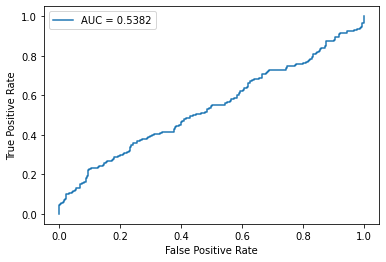

In [64]:
from sklearn.metrics import roc_curve

y_pred = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(test_data.classes, y_pred)
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()